In [1]:
import numpy as np
import pandas as pd
import glob
import os
from scipy import signal
from matplotlib import pyplot as plt
import datain

In [2]:
def decimate(data,tarr=np.array([]), decfac=1):
    reshaped=data.reshape(int(data.size/decfac),decfac)
    decimated=np.mean(reshaped,axis=1)
    if tarr.size>0:
        tarre=tarr[::decfac]
        return decimated, tarre
    else:
        return decimated

def sigavg(data, freq,tarr=np.array([]), sampf=50000, cycle=1, decfac=1):
    tf=data.size/sampf
    wfm=tf*freq
    wfmck=np.remainder(wfm,cycle)
    if wfmck>0.0:
        return 'Data not integer cycles'
    else:
        datare=data.reshape(int(wfm),int(sampf/freq))
        datavg=np.mean(datare,axis=0)
    
    if tarr.size>0:
        tarre=tarr[:int(sampf/freq)]
        return datavg, tarre
    else:
        return datavg
    
def getfft(data, tarr=np.array([])):
    datafft=np.zeros(np.shape(data))+1j*0
    Ns=np.shape(data)[1]
    
    if tarr.size>0:
        dt=tarr[1]
        freq=np.fft.fftshift(np.fft.fftfreq(Ns,dt))
        datafft=np.fft.fftshift(np.fft.fft(data)/(Ns/2))#Ns)
        del data, tarr
        return datafft, freq
    else:
        datafft=np.fft.fftshift(np.fft.fft(data)/(Ns/2))#Ns)
        del data, tarr
        return datafft
    
def submean(data):
    data=data-np.mean(data)
    return data

In [20]:
def fullanalyze(data, fa, dec):
    #Reads data, subtracts mean from current (J) and voltage (V) signals but not from X-ray ratio (Ir)
    #Adjusts phase of all signals to mimic a sine wave
    #Decimates by a factor "dec" to reduce sampling rate (e.g. 5000 samples becomes 50 with dec=100)
    #Signal averages down to one period of frequency = fa after decimating signal

    Ir=np.array(data['If']/data['Io'])
    Imean=np.mean(Ir)
    datan=np.array([data['Time'],submean(Ir),submean(data['J']),submean(data['V'])])

    Ns=datan[0,:].size
    dt=datan[0,1]

    datafft, freq=getfft(datan[1:,:],datan[0,:])

    fftang=np.angle(datafft)
    fftmag=np.abs(datafft)
    bin1=datain.fftbin(fa,freq,Ns,dt,"Real",1)
    angadj=fftang[0,int(bin1[1])]+np.pi/2
    angadj2=fftang[1,int(bin1[1])]+np.pi/2
    angadj3=fftang[2,int(bin1[1])]+np.pi/2

    fftang2=fftang

    fftang2[0,int(Ns/2):]=fftang[0,int(Ns/2):]-angadj #adjusting positive frequencies
    fftang2[0,:int(Ns/2)]=fftang[0,:int(Ns/2)]+angadj #adjusting negative frequencies

    fftang2[1,int(Ns/2):]=fftang[1,int(Ns/2):]-angadj2 #adjusting positive frequencies
    fftang2[1,:int(Ns/2)]=fftang[1,:int(Ns/2)]+angadj2 #adjusting negative frequencies

    fftang2[2,int(Ns/2):]=fftang[2,int(Ns/2):]-angadj3 #adjusting positive frequencies
    fftang2[2,:int(Ns/2)]=fftang[2,:int(Ns/2)]+angadj3 #adjusting negative frequencies

    datafft2=datain.P2R(fftmag,fftang2)

    dataffti=np.fft.ifft(np.fft.ifftshift(datafft2)*Ns/2)

    t=datan[0,:]
    Ir=dataffti[0,:]
    V=dataffti[1,:]
    J=dataffti[2,:]

    # fa=0.5
    # dec=2000
    fs=50000

    Irdec,tdec=decimate(Ir,tarr=t,decfac=dec)
    Iav,tav=sigavg(Irdec, freq=fa,tarr=tdec,sampf=fs/dec,decfac=dec)
    Vav=sigavg(decimate(V,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    Jav=sigavg(decimate(J,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)

    Iav=Iav+Imean

    datav=np.array([[tav,Iav,Vav,Jav]])
    return datav


def partanalyze(data, fa, dec):
    #Reads data, subtracts mean from current (J) and voltage (V) signals but not from X-ray ratio (Ir)
    #Decimates by a factor "dec" to reduce sampling rate (e.g. 5000 samples becomes 50 with dec=100)
    #Signal averages down to one period of frequency = fa after decimating signal
    
    Ir=np.array(data['If']/data['Io'])
    t=np.array(data['Time'])
    J=submean(np.array(data['J']))
    V=submean(np.array(data['V']))
    
    fs=50000
    
    Irdec,tdec=decimate(Ir,tarr=t,decfac=dec)
    Iav,tav=sigavg(Irdec, freq=fa,tarr=tdec,sampf=fs/dec,decfac=dec)
    Vav=sigavg(decimate(V,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    Jav=sigavg(decimate(J,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
    
    datav=np.array([[tav,Iav,Vav,Jav]])
    return datav

def readolddata(path, decfac, fa):
    
    fsamp=50000
    samplen=int(fsamp*60/(decfac*60*fa))
    
    data=np.genfromtxt(path, delimiter=' ', dtype=complex)
    dum2d=data[~np.isnan(data)]
    dum2d=dum2d.reshape(data.shape[0],int(dum2d.size/data.shape[0]))
    del data
    dum3d=dum2d.reshape(np.roll([68,4,samplen],1)).transpose(1,2,0)
    
    return dum3d

In [16]:
dec=2000
fa=0.5
fs=50000

Ir=np.array(data['If']/data['Io'])
t=np.array(data['Time'])
J=np.array(data['J'])
V=np.array(data['V'])

Irdec,tdec=decimate(Ir,tarr=t,decfac=dec)
Iav,tav=sigavg(Irdec, freq=fa,tarr=tdec,sampf=fs/dec,decfac=dec)
Vav=sigavg(decimate(V,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
Jav=sigavg(decimate(J,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)

In [4]:
## path=r'G:/My Drive/UW Research/Dynamic XAS Data/Energy Spectrum_0.5Hz/Txt Files'
# path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data\E90.txt'
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data'
initfile=53
finfile=120
filea=np.r_[initfile:finfile+1]
for n in filea:
    filestr=str(path+'/E'+str(n)+'.txt')
    print(filestr)
    all_files=glob.glob(filestr)
    data=pd.read_csv(filestr,delimiter='\t', header=None,engine='python')
    data.columns=('Time','Io','If','J','V') #Io is incident X-ray, If is fluroesced X-ray
    if n==filea[0]:
        print('first')
        dum1=fullanalyze(data, 0.5,5000)
#         dum1=partanalyze(data,0.5,2000)
    else:
        print(n)    
        dum1=np.concatenate((dum1,fullanalyze(data,0.5,5000)),axis=0)
#         dum1=dum1=np.concatenate((dum1,partanalyze(data,0.5,2000)),axis=0)

    
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

dum2=dum1
dum2d=dum2.transpose(2,0,1).reshape(-1,dum2.shape[1])
dum2d.shape

C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E53.txt
first
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E54.txt
54
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E55.txt
55
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E56.txt
56
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E57.txt
57
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E58.txt
58
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E59.txt
59
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E60.txt
60
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E61.txt
61
C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spe

(1360, 4)

In [5]:
np.savetxt('Dynamic XAS Energy analyzed data\ESweep0_5Hz_53-120_ReaddMean_PhsCorrect.txt', dum2d,fmt='%.8e')

In [26]:
dum3d=dum2d.reshape(np.roll([180,4,20],1)).transpose(1,2,0)

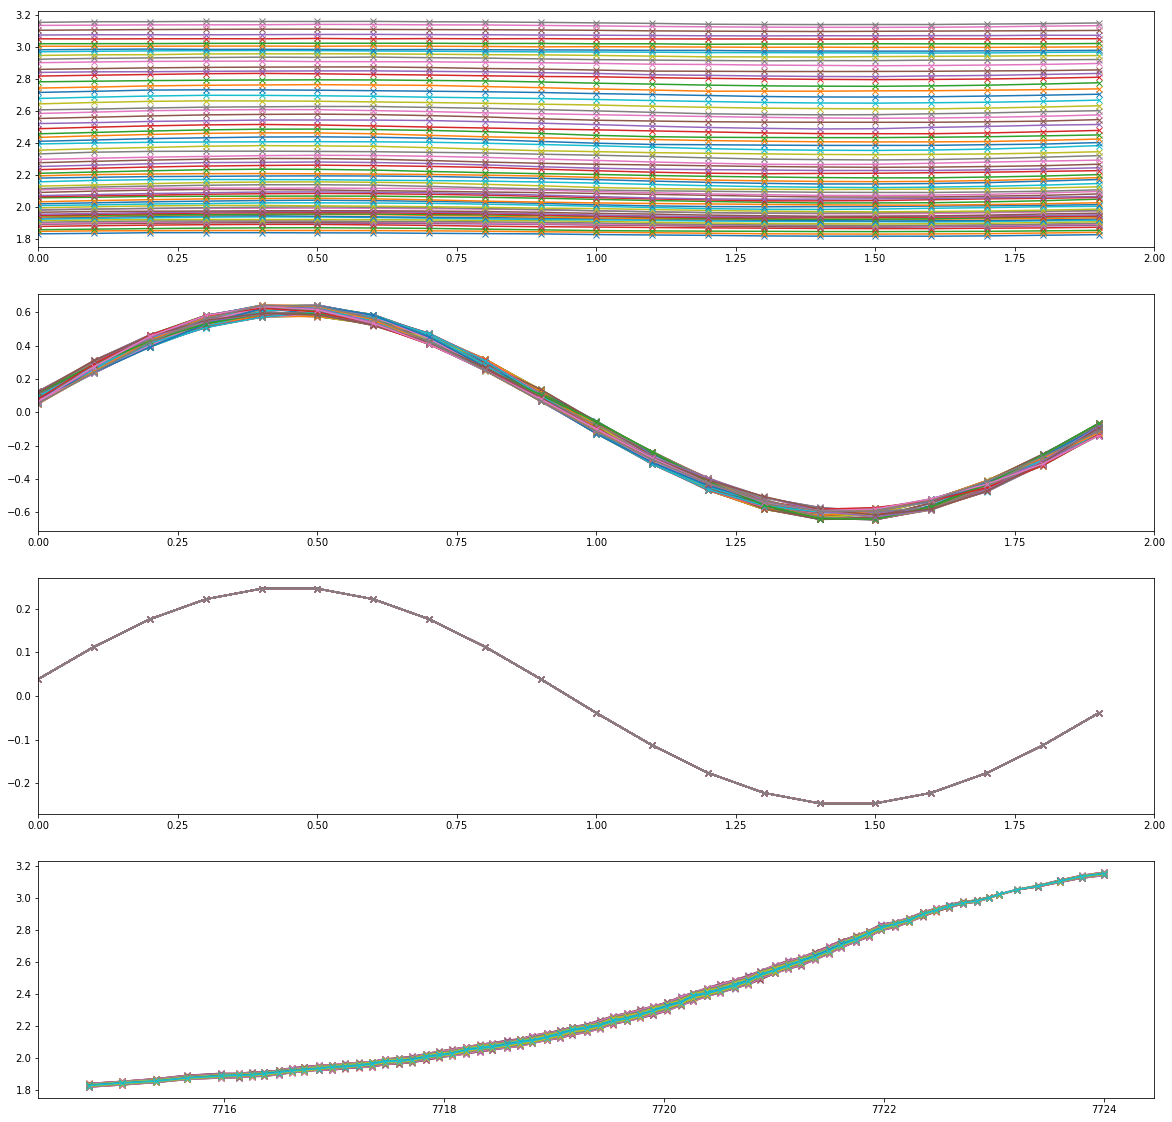

In [25]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data\ESweep0_5Hz_53-120_ReaddMean_PhsCorrect.txt'

dum1=readolddata(path,5000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

fig=plt.figure(figsize=(20,20))

ax1=fig.add_subplot(411)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-x') 
ax1.set_xlim(0,2)

ax1=fig.add_subplot(412)
ax1.plot(dum1[:,0,:].T,dum1[:,2,:].T,'-x') 
ax1.set_xlim(0,2)

ax1=fig.add_subplot(413)
ax1.plot(dum1[:,0,:].T,dum1[:,3,:].T,'-x') 
ax1.set_xlim(0,2)

ax1=fig.add_subplot(414)
ax1.plot(Edum[:,52:120].T,dum1[:,1,:],'-x') 
# ax1.set_xlim(7718,7720)
# ax1.set_ylim(1.9,2.4)

plt.show()

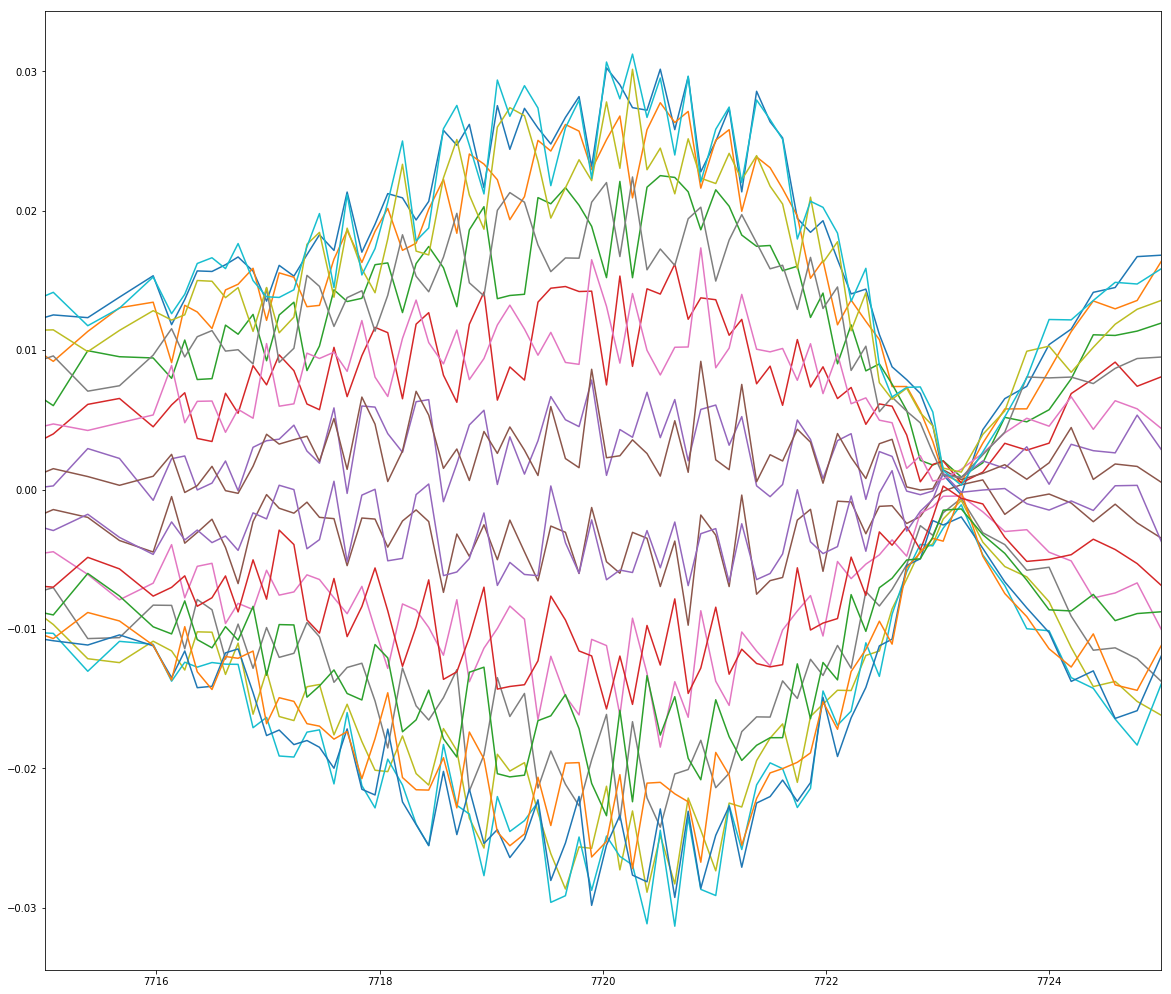

In [39]:
fig=plt.figure(figsize=(20,60))

ax1=fig.add_subplot(311)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)


plt.show()

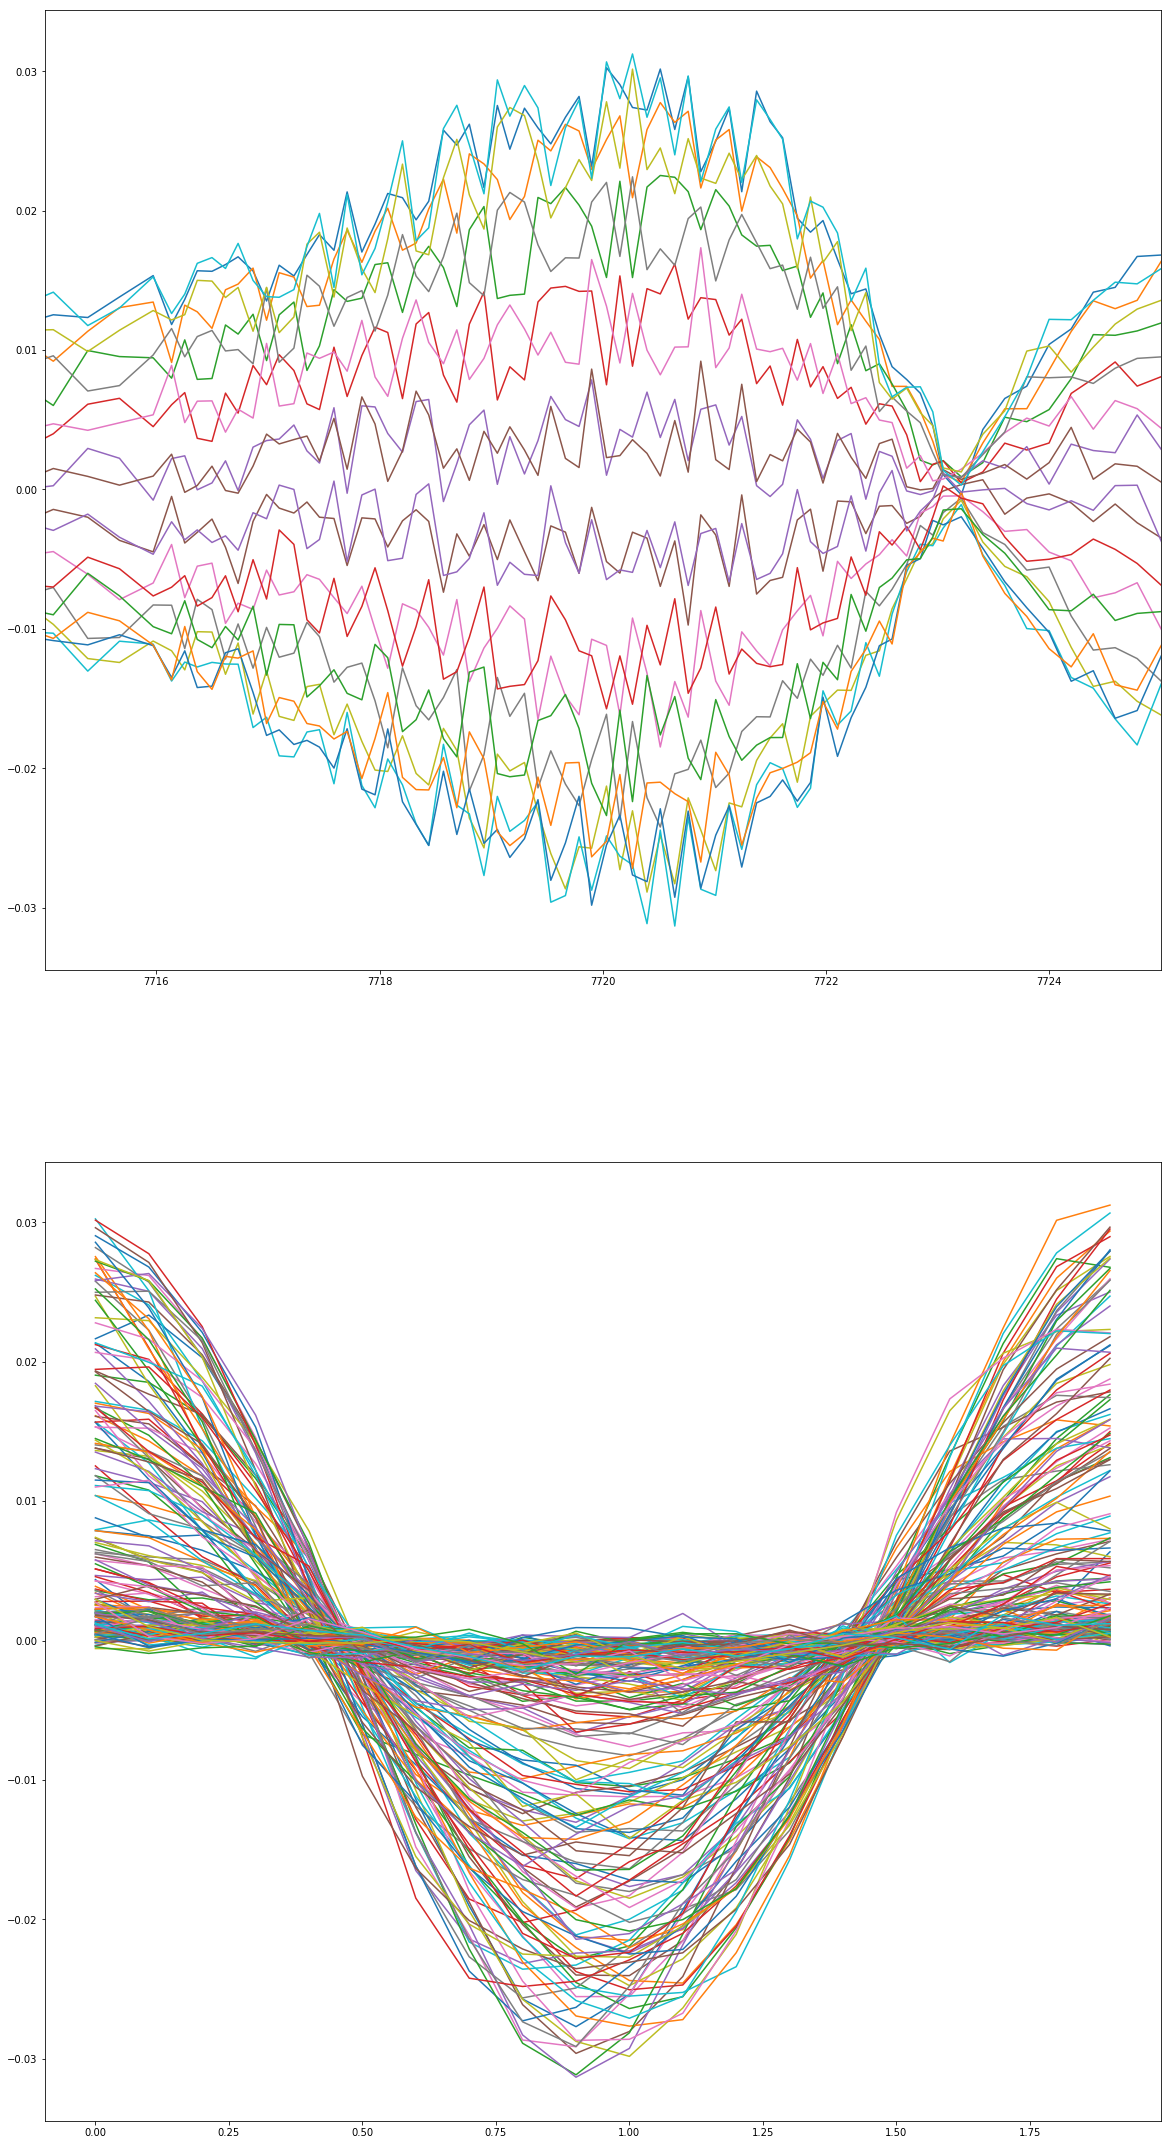

In [65]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\ESweep0_5Hz_Subtracted Means.txt'

dum1=readolddata(path,5000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

fig=plt.figure(figsize=(20,60))

ax1=fig.add_subplot(311)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)

ax1=fig.add_subplot(312)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-')
# ax1.set_xlim(0,3)


plt.show()

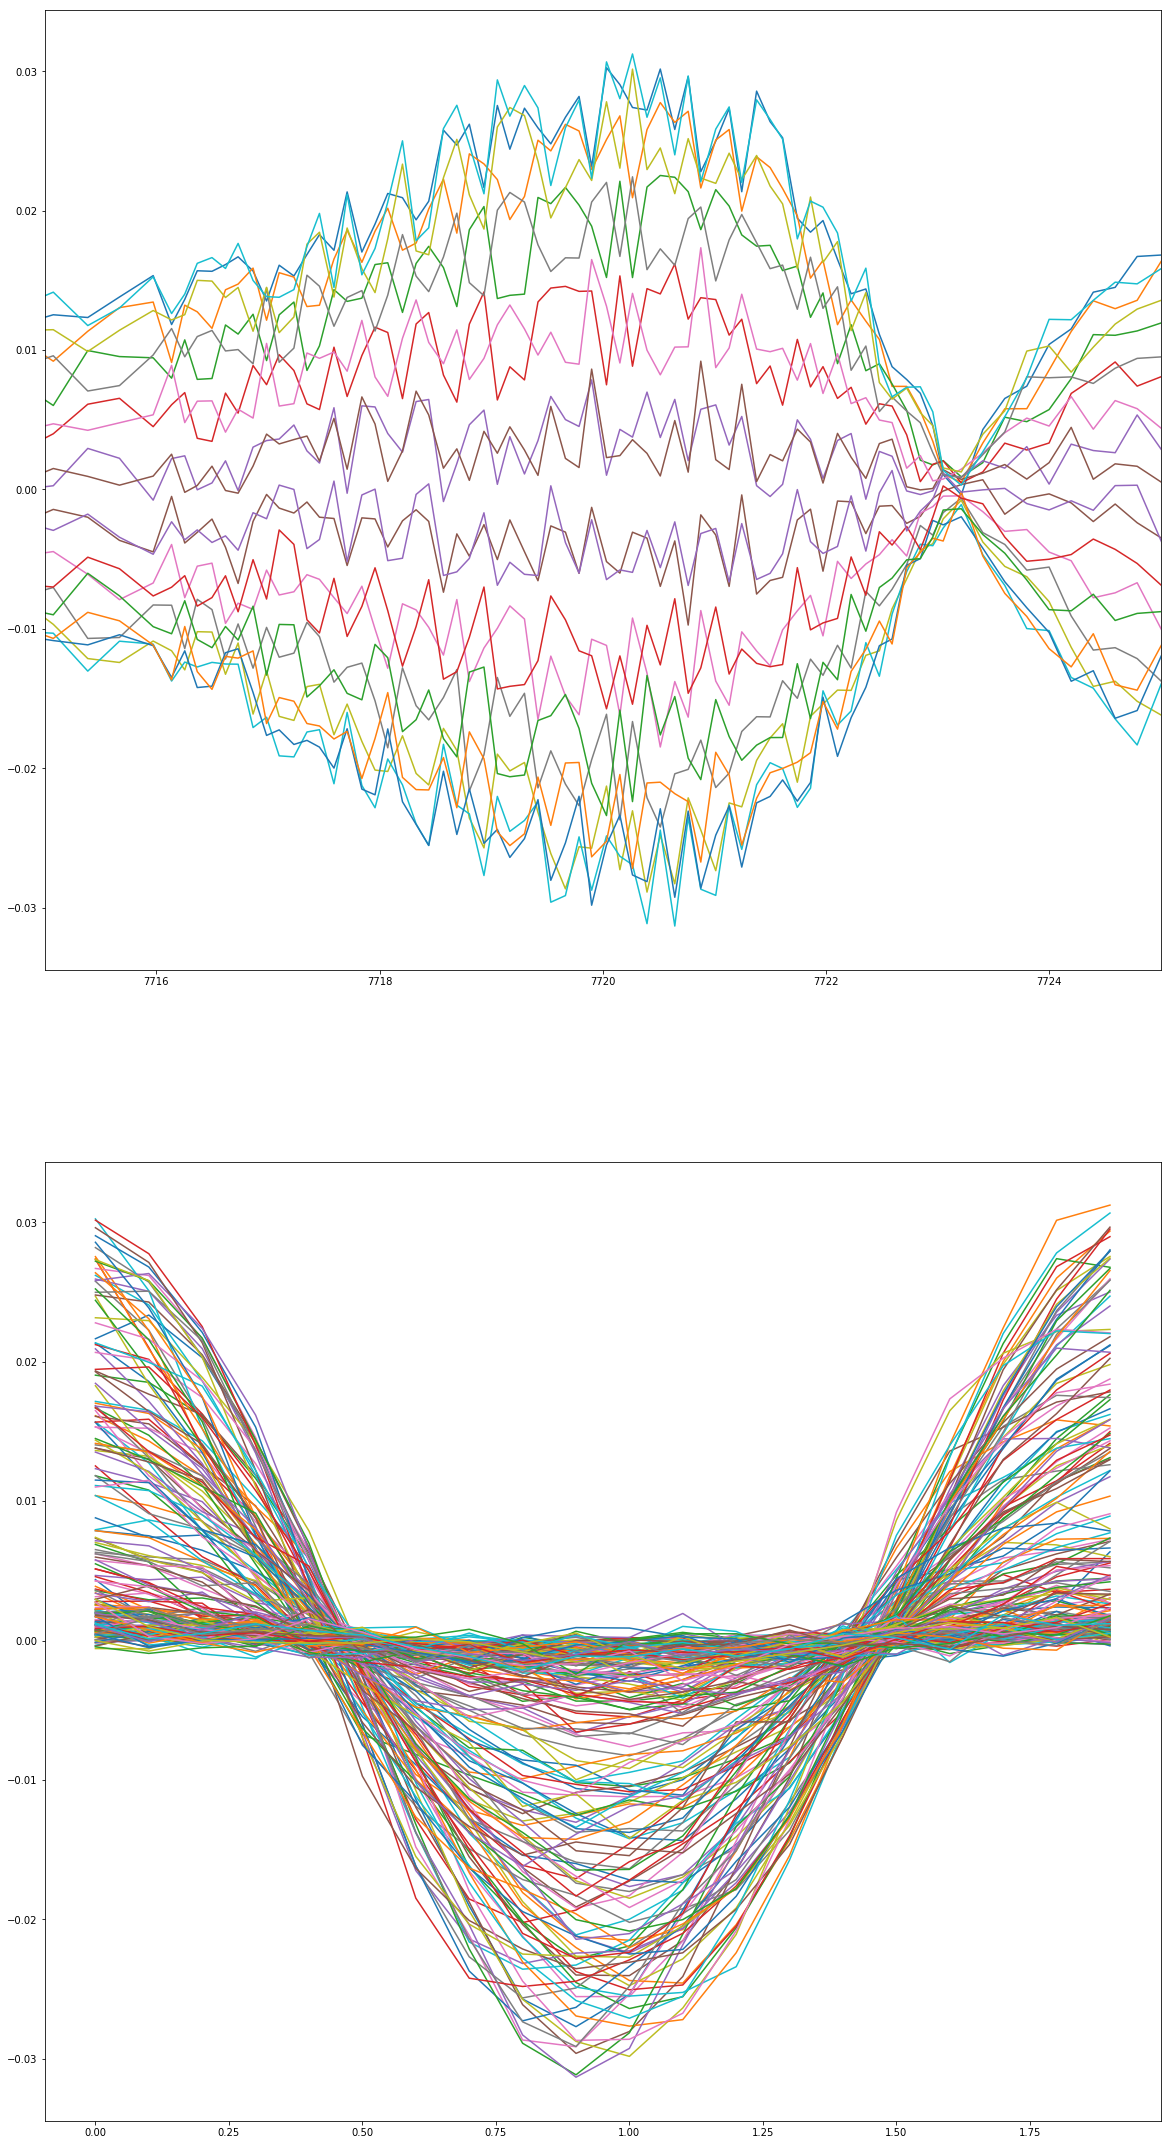

In [13]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data\ESweep0_5Hz_AlsoSubtracted Means.txt'

dum1=readolddata(path,5000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

fig=plt.figure(figsize=(20,60))

ax1=fig.add_subplot(311)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)

ax1=fig.add_subplot(312)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-')

plt.show()

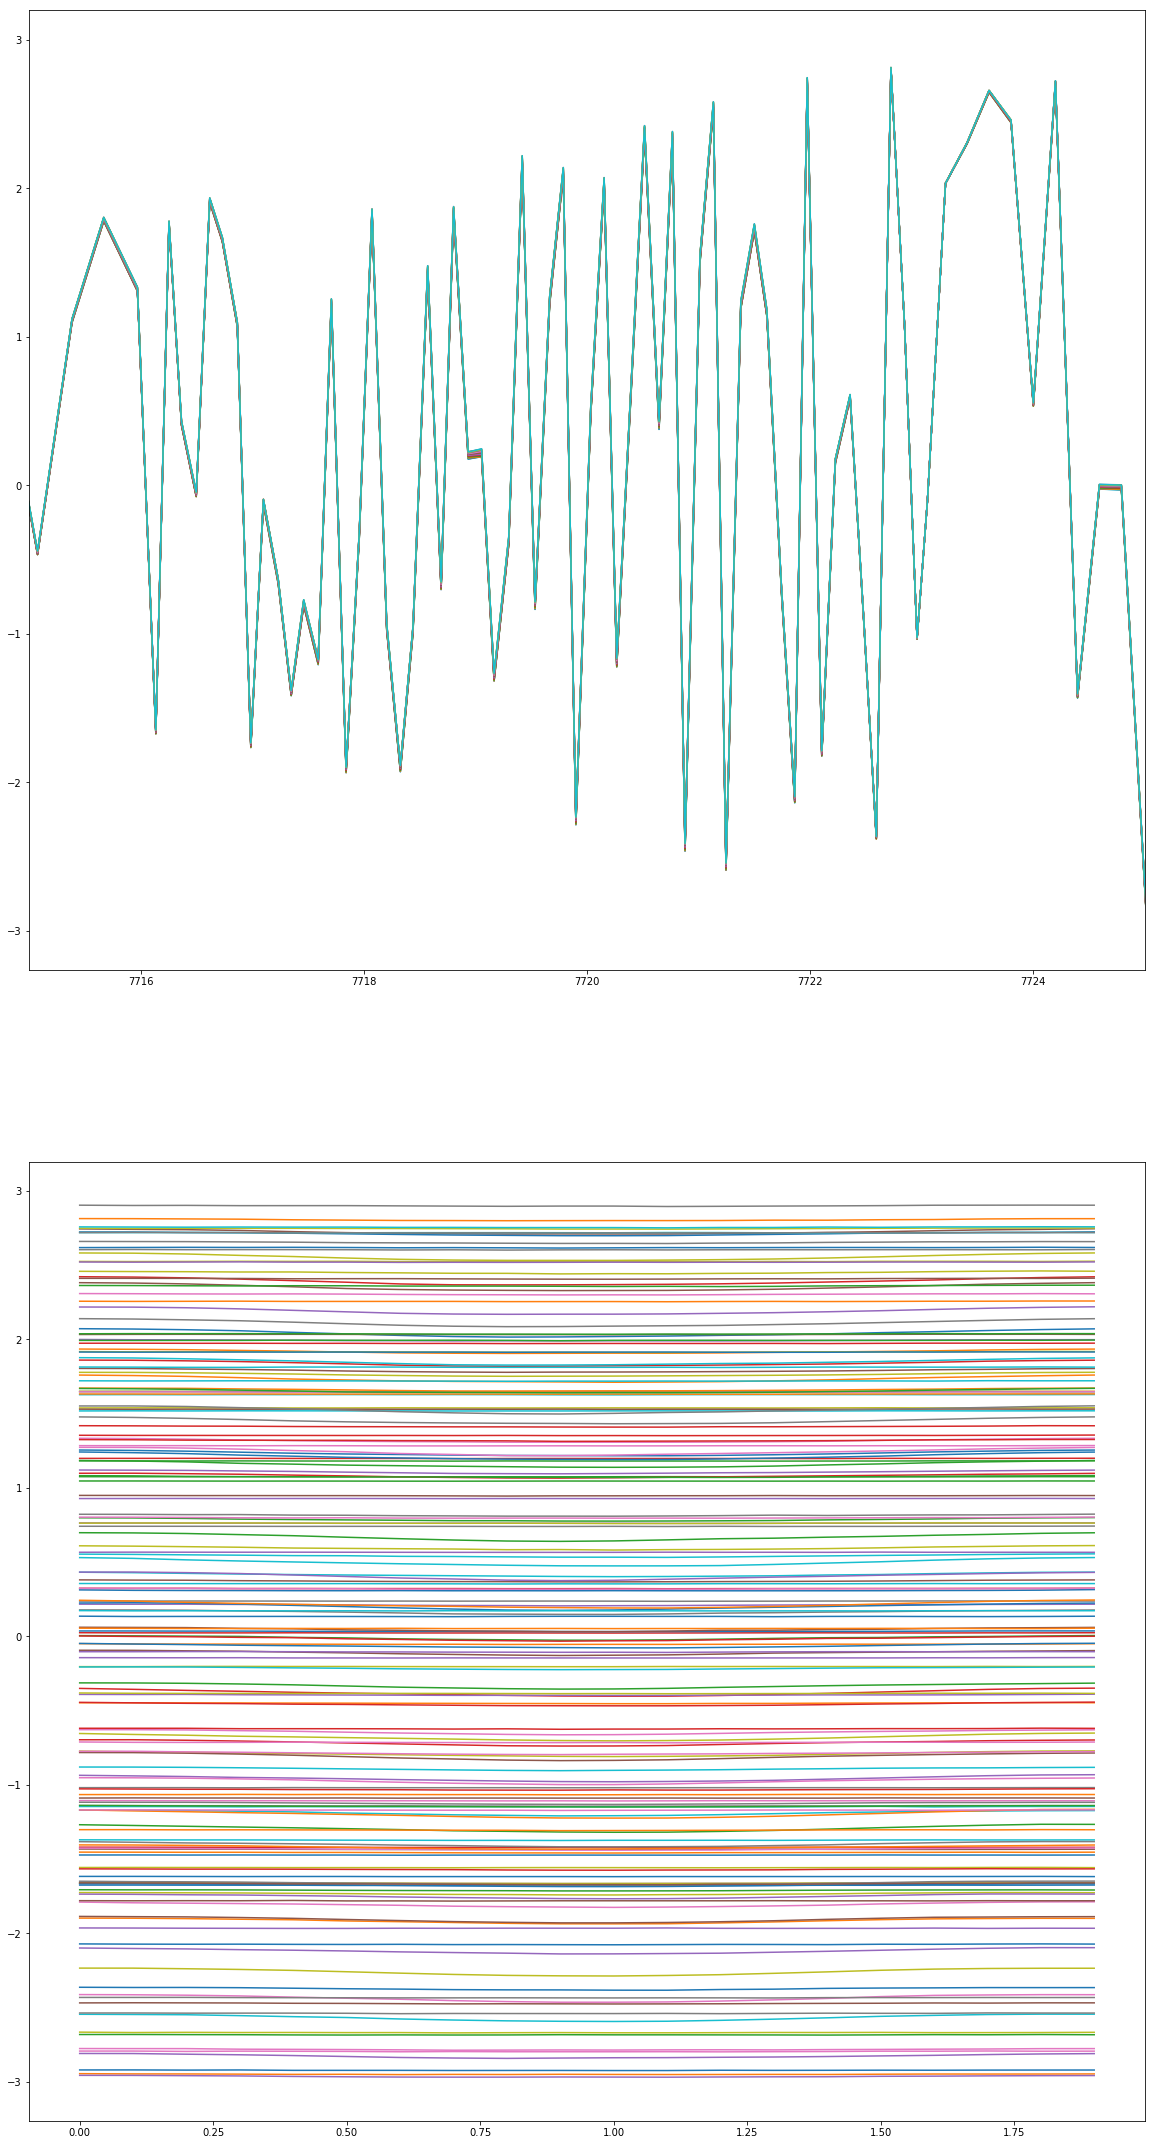

In [16]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data\ESweep0_5Hz_NoSub.txt'

dum1=readolddata(path,5000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

fig=plt.figure(figsize=(20,60))

ax1=fig.add_subplot(311)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)

ax1=fig.add_subplot(312)
ax1.plot(dum1[:,0,:].T,dum1[:,1,:].T,'-')

plt.show()

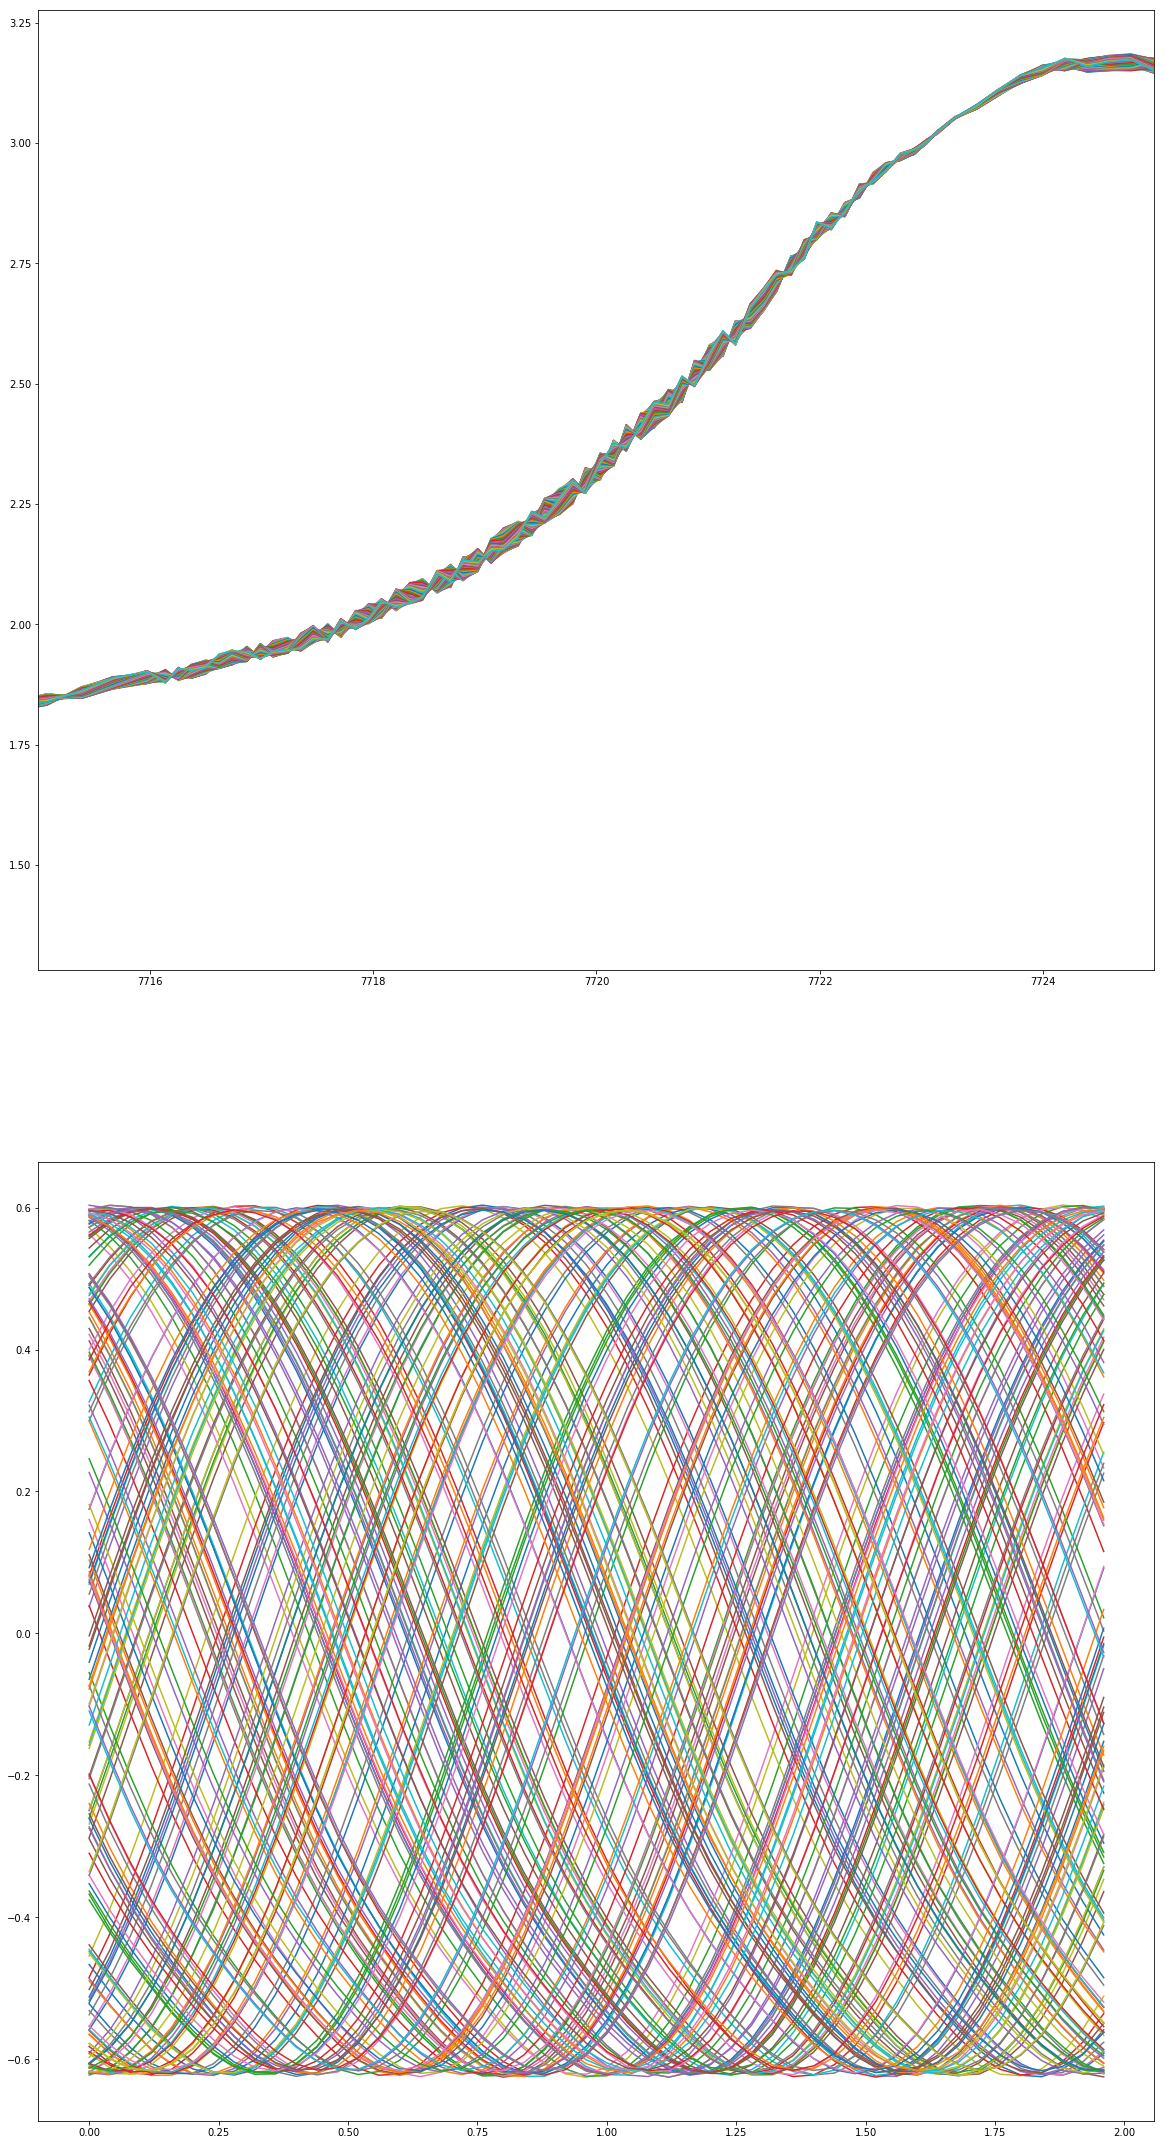

In [17]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy analyzed data\ESweep0_5Hz_NoPhsCorrectNoSub.txt'

dum1=readolddata(path,2000,0.5)


path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Energy List.txt'

Elist=pd.read_csv(path, header=None)
Elist=np.array(Elist[0])

Edum=np.tile(Elist,dum1.shape[2])
Edum.resize(dum1.shape[2],Elist.size)

fig=plt.figure(figsize=(20,60))

ax1=fig.add_subplot(311)
ax1.plot(Edum[:,:].T,dum1[:,1,:],'-') 
ax1.set_xlim(7715,7725)

ax1=fig.add_subplot(312)
ax1.plot(dum1[:,0,:].T,dum1[:,3,:].T,'-')

plt.show()

In [43]:
del data, dum2d, dum3d, dum1

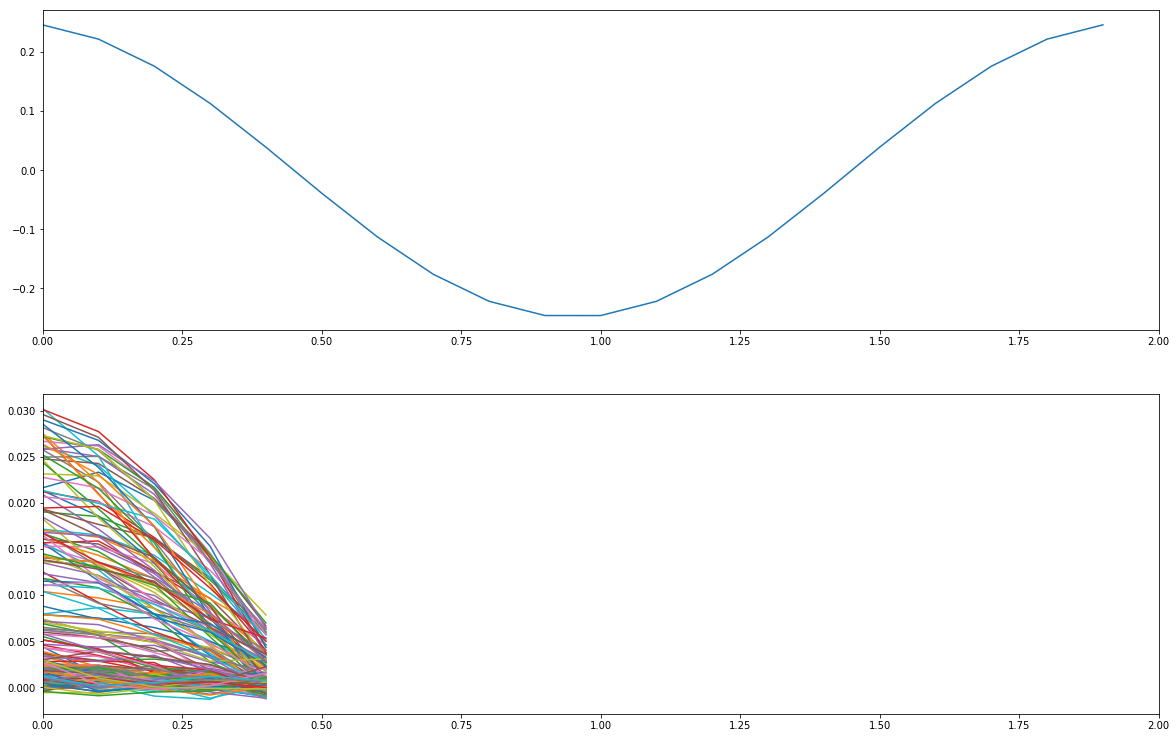

In [38]:
fig=plt.figure(figsize=(20,20))

ax1=fig.add_subplot(311)
ax1.plot(np.real(dum1[0,0,:]),dum1[85,3,:])
ax1.set_xlim(0,2)

ax1=fig.add_subplot(312)
ax1.plot(np.real(dum1[:,0,0:5].T),dum1[:,1,0:5].T)
ax1.set_xlim(0,2)

plt.show()

In [110]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data'
initfile=80
finfile=80
filea=np.r_[initfile:finfile+1]
for n in filea:
    filestr=str(path+'/E'+str(n)+'.txt')
    print(filestr)
    all_files=glob.glob(filestr)
    data=pd.read_csv(filestr,delimiter='\t', header=None,engine='python')
    data.columns=('Time','Io','If','J','V') #Io is incident X-ray, If is fluroesced X-ray
    if n==filea[0]:
        print('first')
#         dum1=fullanalyze(data, 0.5,2000)
        dum1=np.array(data,ndmin=3)
    else:
        print(n)    
#         dum1=np.concatenate((dum1,fullanalyze(data,0.5,2000)),axis=0)
        dum1=dum1=np.concatenate((dum1,np.array(data,ndmin=3)),axis=0).transpose(0,2,1)

C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data/E80.txt
first


In [111]:
    #Reads data, subtracts mean from current (J) and voltage (V) signals but not from X-ray ratio (Ir)
    #Adjusts phase of all signals to mimic a sine wave
    #Decimates by a factor "dec" to reduce sampling rate (e.g. 5000 samples becomes 50 with dec=100)
    #Signal averages down to one period of frequency = fa after decimating signal
dec=5000
fa=0.5

Ir=np.array(data['If']/data['Io'])
Imean=np.mean(Ir)
datan=np.array([data['Time'],submean(Ir),submean(data['J']),submean(data['V'])])

Ns=datan[0,:].size
dt=datan[0,1]

datafft, freq=getfft(datan[1:,:],datan[0,:])

fftang=np.angle(datafft)
fftmag=np.abs(datafft)
bin1=datain.fftbin(fa,freq,Ns,dt,"Real",1)
angadj=fftang[0,int(bin1[1])]+np.pi/2
angadj2=fftang[1,int(bin1[1])]+np.pi/2
angadj3=fftang[2,int(bin1[1])]+np.pi/2

fftang2=fftang

fftang2[0,int(Ns/2):]=fftang[0,int(Ns/2):]-angadj #adjusting positive frequencies
fftang2[0,:int(Ns/2)]=fftang[0,:int(Ns/2)]+angadj #adjusting negative frequencies

fftang2[1,int(Ns/2):]=fftang[1,int(Ns/2):]-angadj2 #adjusting positive frequencies
fftang2[1,:int(Ns/2)]=fftang[1,:int(Ns/2)]+angadj2 #adjusting negative frequencies

fftang2[2,int(Ns/2):]=fftang[2,int(Ns/2):]-angadj3 #adjusting positive frequencies
fftang2[2,:int(Ns/2)]=fftang[2,:int(Ns/2)]+angadj3 #adjusting negative frequencies

datafft2=datain.P2R(fftmag,fftang2)

dataffti=np.fft.ifft(np.fft.ifftshift(datafft2)*Ns/2)

t=datan[0,:]
Ir=dataffti[0,:]
V=dataffti[1,:]
J=dataffti[2,:]

    # fa=0.5
    # dec=2000
fs=50000

Irdec,tdec=decimate(Ir,tarr=t,decfac=dec)
Iav,tav=sigavg(Irdec, freq=fa,tarr=tdec,sampf=fs/dec,decfac=dec)
Vav=sigavg(decimate(V,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
Jav=sigavg(decimate(J,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)

Iav=Iav+Imean
    
datav=np.array([[tav,Iav,Vav,Jav]])


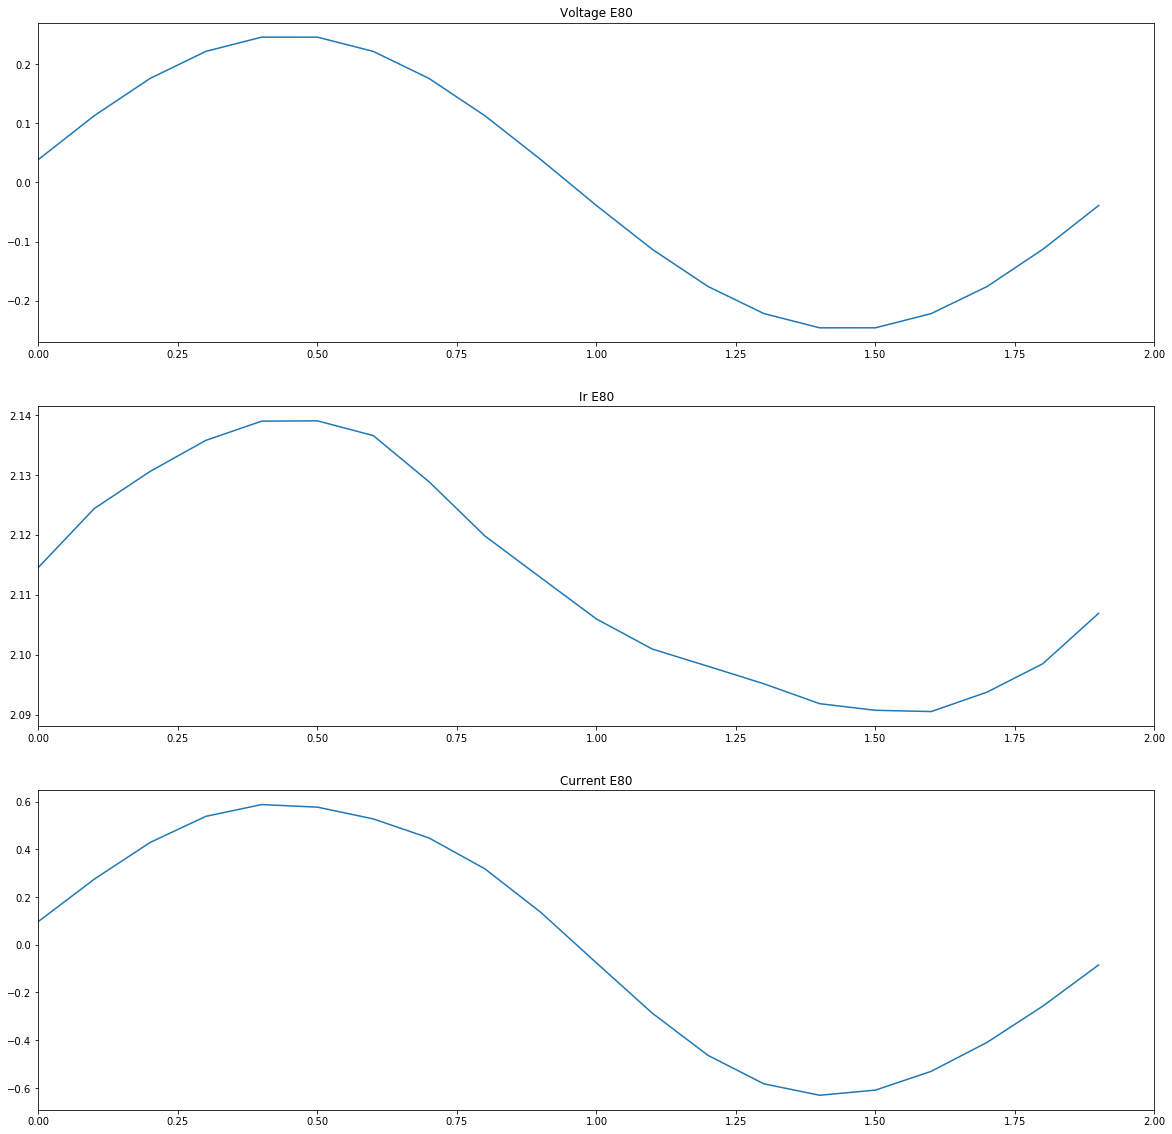

In [112]:
fig=plt.figure(figsize=(20,20))

ax1=fig.add_subplot(311)
ax1.plot(datav[0,0,:],datav[0,3,:])
ax1.set_title(str('Voltage E'+str(initfile)))
ax1.set_xlim(0,2)

ax1=fig.add_subplot(312)
ax1.plot(datav[0,0,:],datav[0,1,:])
ax1.set_title(str('Ir E'+str(initfile)))
ax1.set_xlim(0,2)

ax1=fig.add_subplot(313)
ax1.plot(datav[0,0,:],datav[0,2,:])
ax1.set_title(str('Current E'+str(initfile)))
ax1.set_xlim(0,2)

plt.show()

In [114]:
fig.savefig('Dynamic XAS Energy Plots\E'+ str(initfile)+'plots Readd Mean With Phs Corr.png')

# Old code below. Probably still works-- mostly process of figuring out the fullanalyze function

In [3]:
#path=r'G:/My Drive/UW Research/Dynamic XAS Data/Energy Spectrum_0.5Hz/Txt Files/E85.txt'
path=r'C:\Users\shadd\OneDrive\Documents\Python\fr_XAS\Dynamic XAS Energy Spectrum 0_5Hz test data\E85.txt'
all_files=glob.glob(path)
data=pd.read_csv(path,delimiter='\t', header=None)
data.columns=('Time','Io','If','J','V') #Io is incident X-ray, If is fluroesced X-ray

Ir=np.array(data['If']/data['Io'])
datan=np.array([data['Time'],submean(Ir),submean(data['J']),submean(data['V'])])

Ns=datan[0,:].size
dt=datan[0,1]

In [4]:
datafft, freq=getfft(datan[1:,:],datan[0,:])

In [5]:
fftang=np.angle(datafft)
fftmag=np.abs(datafft)
bin1=datain.fftbin(0.5,freq,Ns,dt,"Real",1)
angadj=fftang[0,int(bin1[1])]+np.pi/2
angadj2=fftang[1,int(bin1[1])]+np.pi/2
angadj3=fftang[2,int(bin1[1])]+np.pi/2

fftang2=fftang

fftang2[0,int(Ns/2):]=fftang[0,int(Ns/2):]-angadj #adjusting positive frequencies
fftang2[0,:int(Ns/2)]=fftang[0,:int(Ns/2)]+angadj #adjusting negative frequencies

fftang2[1,int(Ns/2):]=fftang[1,int(Ns/2):]-angadj2 #adjusting positive frequencies
fftang2[1,:int(Ns/2)]=fftang[1,:int(Ns/2)]+angadj2 #adjusting negative frequencies

fftang2[2,int(Ns/2):]=fftang[2,int(Ns/2):]-angadj3 #adjusting positive frequencies
fftang2[2,:int(Ns/2)]=fftang[2,:int(Ns/2)]+angadj3 #adjusting negative frequencies

datafft2=datain.P2R(fftmag,fftang2)

In [6]:
print(np.shape(fftang))
print(np.angle(datafft[2,int(bin1[0])+1]),np.angle(datafft[2,int(bin1[1])]))
print(freq[int(bin1[1]):int(bin1[1])+3])
print(freq[int(bin1[0])-1:int(bin1[0])+3])
print(angadj,np.angle(datafft2[1,int(bin1[0])]))
print(fftang[2,int(bin1[1])+4],fftang2[2,int(bin1[1])+4])

(3, 3000000)
-0.9424556956177024 0.9424556956177024
[0.5        0.51666667 0.53333333]
[-0.53333333 -0.51666667 -0.5        -0.48333333]
2.513252022412599 -1.714993984058784
-1.629210258963357 -1.629210258963357


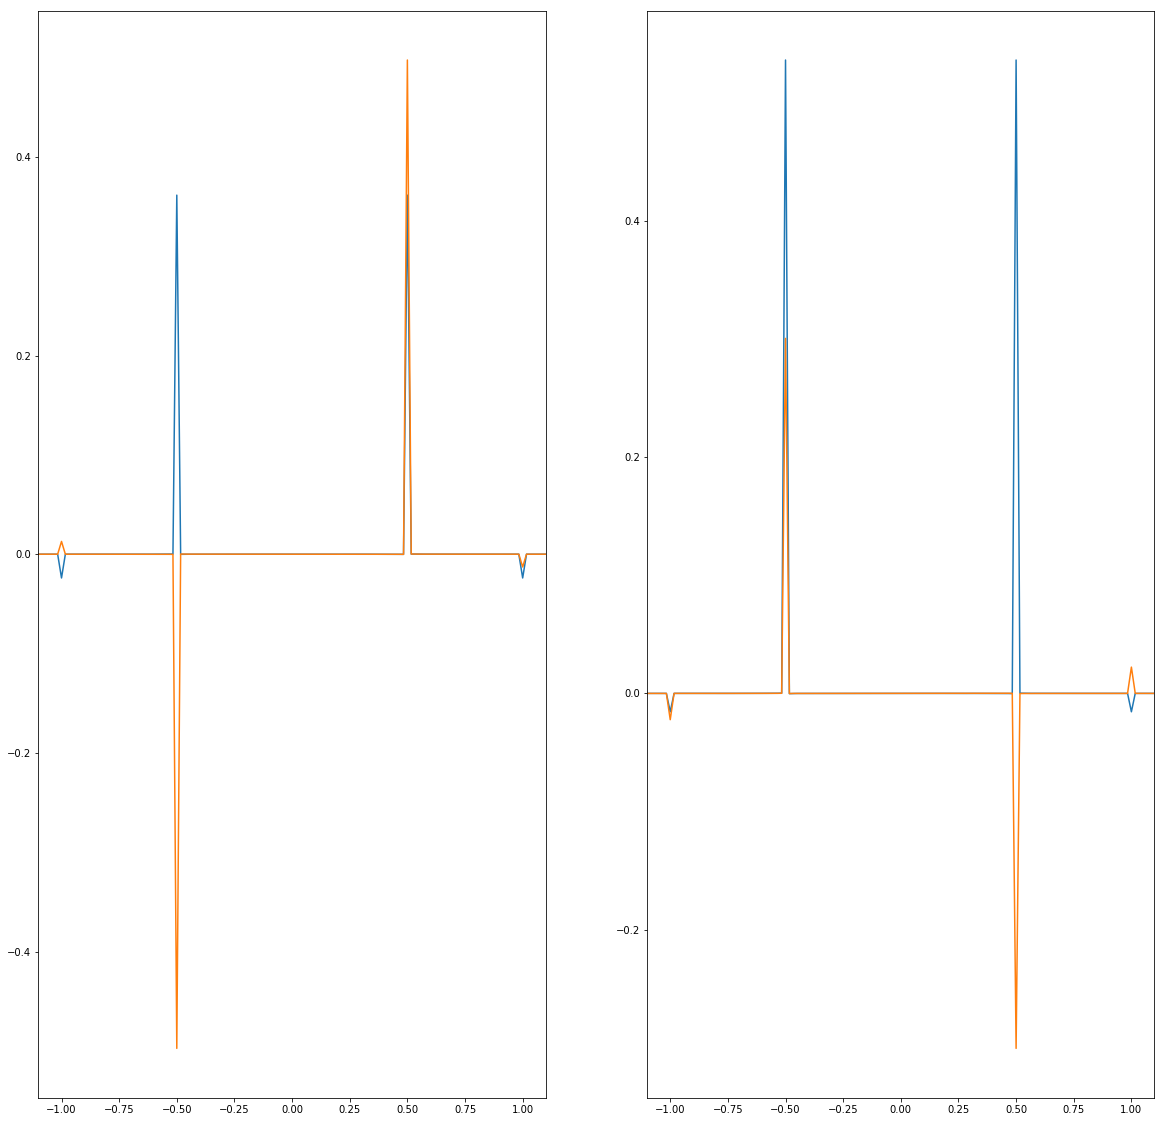

In [16]:
fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(121)

ax1.plot(freq,np.real(datafft[2,:]),freq,np.imag(datafft[2,:]))
ax1.set_xlim(-1.1,1.1)

ax1=fig.add_subplot(122)

ax1.plot(freq,np.real(datafft2[2,:]),freq,np.imag(datafft2[2,:]))
ax1.set_xlim(-1.1,1.1)
# ax1.set_ylim(0,.001)
plt.show()

In [6]:
dataffti=np.fft.ifft(np.fft.ifftshift(datafft2)*Ns/2)

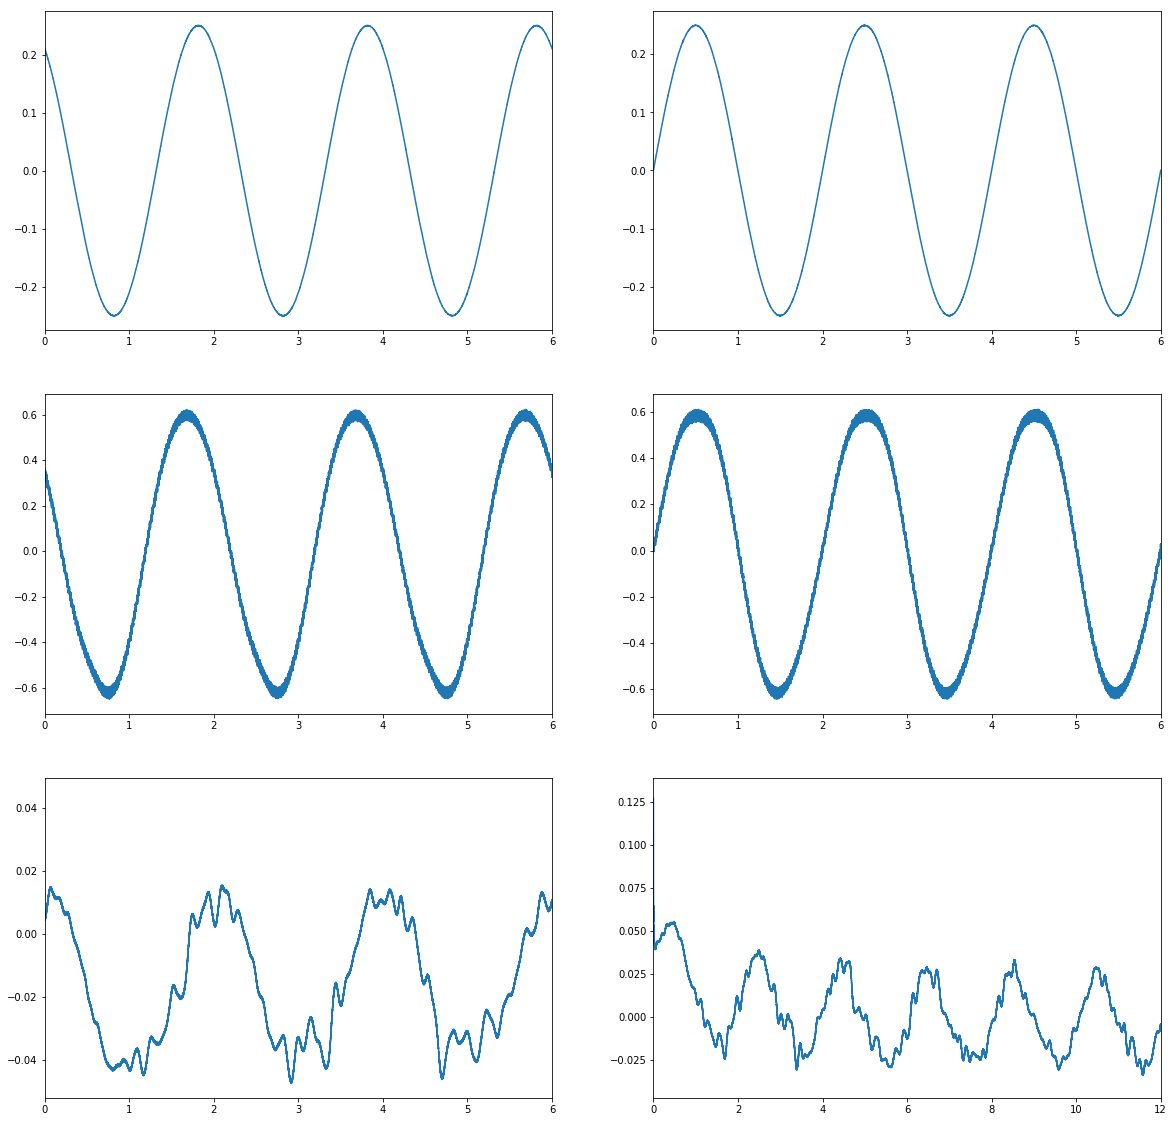

In [8]:
fig=plt.figure(figsize=(20,20))

ax1=fig.add_subplot(321)
ax1.plot(datan[0,:],datan[3,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(322)
ax1.plot(datan[0,:],dataffti[2,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(323)
ax1.plot(datan[0,:],datan[2,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(324)
ax1.plot(datan[0,:],dataffti[1,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(325)
ax1.plot(datan[0,:],datan[1,:])
ax1.set_xlim(0,6)

ax1=fig.add_subplot(326)
ax1.plot(datan[0,:],dataffti[0,:])
ax1.set_xlim(0,6)

plt.show()

In [10]:
t=datan[0,:]
Ir=dataffti[0,:]
V=dataffti[1,:]
J=dataffti[2,:]

In [13]:
fa=0.5
dec=2000
fs=50000

Irdec,tdec=decimate(Ir,tarr=t,decfac=dec)
Iav,tav=sigavg(Irdec, freq=fa,tarr=tdec,sampf=fs/dec,decfac=dec)
Vav=sigavg(decimate(V,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)
Jav=sigavg(decimate(J,decfac=dec),freq=fa,sampf=fs/dec,decfac=dec)

Iav=Iav-np.mean(Iav)
Vav=Vav-np.mean(Vav)
Jav=Jav-np.mean(Jav)

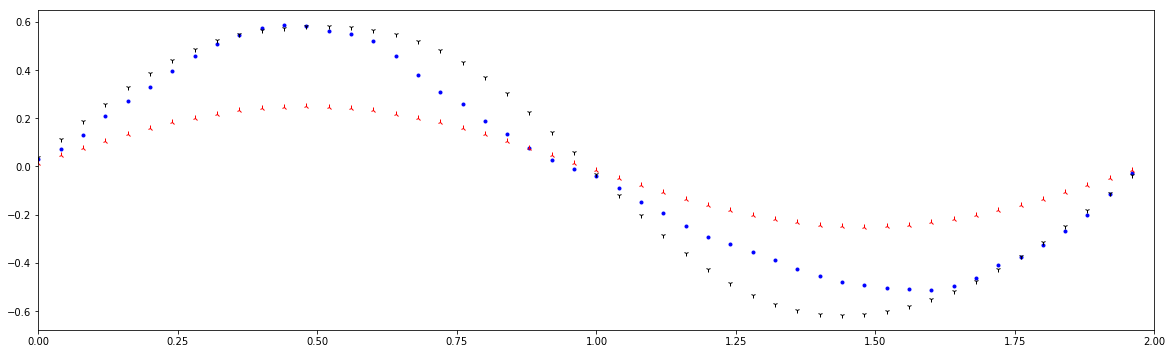

In [14]:
fig=plt.figure(figsize=(20,20))

# ax1=fig.add_subplot(311)
# ax1.plot(tdec,Idec1,'b.',tdec,Idec2,'k1',tdec,Idec3,'r2', tav,Iav,'g3')
# ax1.set_xlim(0,4)

# ax1=fig.add_subplot(312)
# ax1.plot(tdec,Idiff1,'b.',tdec,Idiff2,'k1',tdec,Idiff3,'r2')
# ax1.set_xlim(0,4)

ax1=fig.add_subplot(313)
ax1.plot(tav,(Iav)*20,'b.',tav,Vav,'k1',tav,Jav,'r2')
ax1.set_xlim(0,2)

plt.show()

In [8]:
decfac=500
Idec1,tdec=decimate(Ir,t,500)
Idec2=signal.resample(Ir,int(len(Ir)/decfac))
Idec3=signal.decimate(signal.decimate(signal.decimate(Ir,10),10),5)

Idiff1=np.sqrt((Idec2-Idec1)**2)
Idiff2=np.sqrt((Idec3-Idec1)**2)
Idiff3=np.sqrt((Idec3-Idec2)**2)
print(Idec1.shape,Idec2.shape,Idec3.shape,tdec.shape)
print(Idiff1.shape,Idiff2.shape,Idiff3.shape)

(6000,) (6000,) (6000,) (6000,)
(6000,) (6000,) (6000,)


In [ ]:
np.save